# Forecast The Global Household Electric Power Consumption

In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn

## Explore The Data

In [2]:
data = pd.read_csv("../data/household_power_consumption.txt", sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
data.shape

(2075259, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


**Attribute Information:**

1. **date**: Date in format dd/mm/yyyy  
2. **time**: time in format hh:mm:ss  
3. **globalactivepower**: household global minute-averaged active power (in kilowatt)  
4. **globalreactivepower**: household global minute-averaged reactive power (in kilowatt)  
5. **voltage**: minute-averaged voltage (in volt)  
6. **global_intensity**: household global minute-averaged current intensity (in ampere)  
7. **submetering1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
8. **submetering2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
9. **submetering3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner  

In [5]:
data.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
from sklearn.impute import SimpleImputer
# impute missing
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data = pd.DataFrame(imp.fit_transform(data), index=data.index, columns=data.columns)

In [8]:
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

There is 2075259 records from 2006-12-16 to 2010-11-26 with 25979 of missing records. We simply fill with mean-value.  
We focus on forecasting the Global_active_power here, which is the **true** or **real** or **actual power** dissipated in the circuit.

In [9]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch
    
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [10]:
# create decimal_time column for time-dependent calculation
data = data.reset_index()
data = data.set_index("dt", drop=False)
data["decimal_time"] = data["dt"].apply(lambda x: toYearFraction(x))
del data["dt"]
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,decimal_time
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006.958151
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006.958153
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006.958154
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006.958156
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006.958158


## Let's Forecast !

First of all, let's revise some concept of the time series.  

Time series can be decomposed as three components, which are **drift**, **seasonal**, and **noise**

$$ y(t) = \mathrm{drift} + \mathrm{seasonal} + \mathrm{noise}. $$

- **Drift**: An overall trend, such as 
$$ y(t) = \mu t. $$
Note that the trend no need to be a linear, it can be quadratic or polynomial or whatever! 

- **Seasonality**: A periodic behavior, such as
$$ y(t) = A\sin(2\pi ft) + B\cos(2\pi ft). $$
where, $f$ is the frequency

- **Noise**: The part of the time series remaining after removing drift and seasonality. It is the residual of a model containing drift and seasonality.

Our approach will be to identify the first two terms to create a baseline model, leaving behind the residuals or noise.

**The steps to time series forecasting:**
1. Plot the time series to see if there is any overall trends and seasonality.
1. Detrend the time series by removing drift and seasonality.
1. Fit a baseline model and calculate the residuals.
1. Analyze the resulting residuals and generate features from the residuals.
1. Train a machine learning model to forecast/predict residuals and add back the baseline model.

###  1. Plot the time series to see if there any overall trends and seasonality.

<AxesSubplot:xlabel='dt', ylabel='Minute average power kW'>

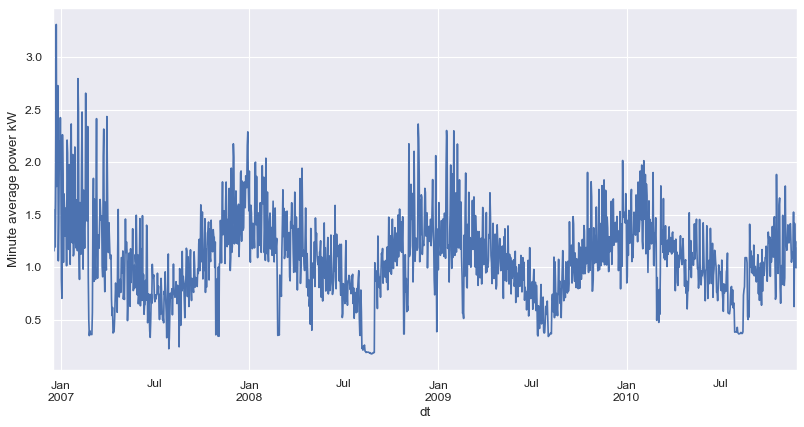

In [11]:
power = data['Global_active_power']
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Minute average power kW')
power.resample('D').mean().plot()

According to the plots, it looks like a stationary TS with seasonality. However, we can create a simple model to capture drift, if it exists, even if we can't notice it.

In [12]:
# We can customize transformer to select the index of df
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, need_reshape=False):
        self.columns = columns
        self.need_reshape = need_reshape

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if self.need_reshape:
            return X[self.columns].values.reshape(-1,1)
        else:
            return X[self.columns]

class IndexSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Return indices of a data frame for use in other estimators."""
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        indices = df.index
        return indices.values.reshape(-1, 1)

In [13]:
def ts_train_test_split(df, cutoff, target):
    """Perform a train/test split on a data frame based on a cutoff date."""
    
    ind = df.index < str(cutoff)
    
    df_train = df.loc[ind]
    df_test = df.loc[~ind]
    y_train = df.loc[ind, target]
    y_test = df.loc[~ind, target]
    
    return df_train, df_test, y_train, y_test

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# perform train/test split
cutoff = 2010
df_train, df_test, y_train, y_test = ts_train_test_split(data, cutoff, 'Global_active_power')

# construct and train pipeline
trend_col = ColumnSelectTransformer("decimal_time", need_reshape=True)
poly = PolynomialFeatures(degree=1)
lr = LinearRegression()
trend_pipe = Pipeline([
    ("select_col", trend_col),
    ("drift", poly)
])
pipe = Pipeline([('trend_feature', trend_pipe),
                 ('regressor', lr)])
pipe.fit(df_train, y_train)

# make predictions
y_pred = pipe.predict(data)
resd = power - y_pred
print("Test set R^2: {:g}".format(pipe.score(df_test, y_test)))

Test set R^2: -0.00160263


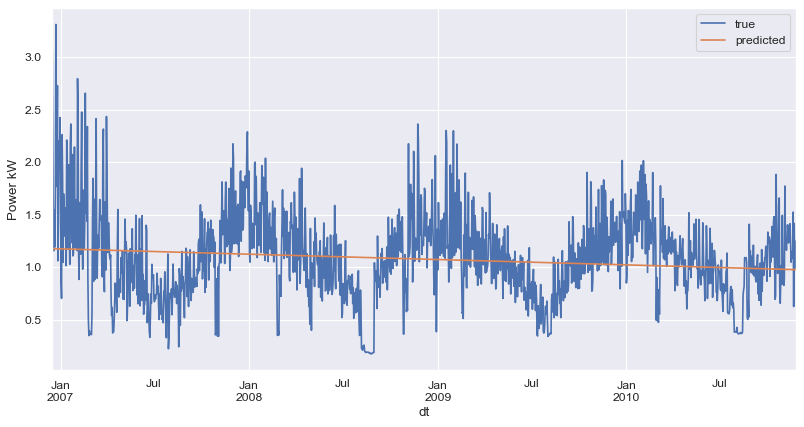

In [15]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

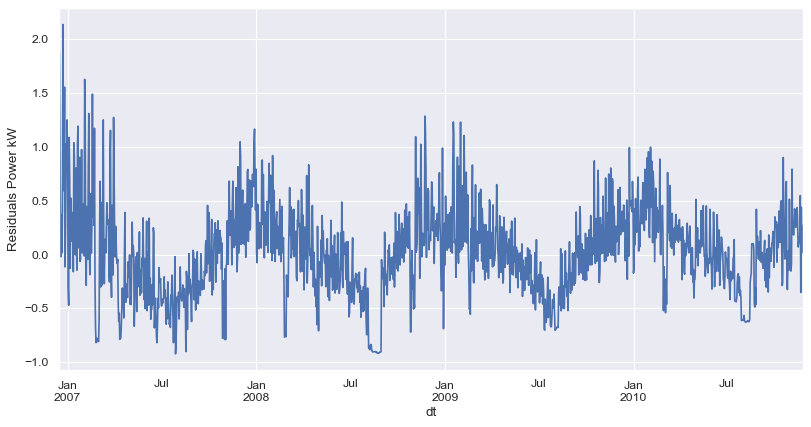

In [16]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd.resample("D").mean().plot()

As the result, the drift is pretty small and the residuals look exactly like the full series itself haha. The R^2 is about -0.0012.  
So, I decide to ignore it. hahaha.  
Let's see what happened with the seasonality.

**Time to crack the seasonality !!**

As your math teacher told you. _"Any signal can be represented as a linear superposition of sines and cosines of varying frequencies $f_n$ and amplitudes $A_n$ and $B_n$"_,

$$ y(t) = \sum_n \left(A_n \sin(2\pi f_n t) + B_n\cos(2 \pi f_n t) \right). $$

Sometime (most of the time), we want to know what is the dominant frequencies that make up a time series.

Here are when the **Fourier transform** comes to save our life.  

The Fourier transform  let us transforme our signal in the time domain into the frequency domain. Since we will be working with discrete data; the signal is sampled at discrete points in time, we will use the **discrete Fourier transform**. For $N$ uniformly sampled time series $y_n$, the transform is defined as

$$ Y_k = \sum^{N-1}_{n=0} y_n e^{-\frac{2\pi i}{N} kn}, $$

$$ Y_k = \sum^{N-1}_{n=0} y_n \left[\cos\left(\frac{2\pi i}{N} kn\right) - i\sin\left(\frac{2\pi i}{N} kn\right) \right], $$

and $i$ is the imaginary number. The term $Y_k$ is the Fourier transform value for a frequency of $k$ cycles in $N$ samples; it is a complex number that represents both the amplitude and phase for its respective sinusoidal component. The amplitude for the frequency $k/N$ is 

$$ |Y_k|/N = \frac{\sqrt{\mathrm{Re}(Y_k)^2 + \mathrm{Im}(Y_k)^2}}{N}. $$

The most common algorithm used to compute the discrete Fourier transform is the fast Fourier transform (FFT). The algorithm makes use of matrix factorization to have a time complexity of $O(n\log n)$ as opposed to the naive  $O(n^2)$ implementation. Note, the time series needs to be uniformly sampled. The `scipy.fftpack` provides the FFT algorithm. Let's use FFT to determine the contributed frequencies in the signal below.

Enough with math

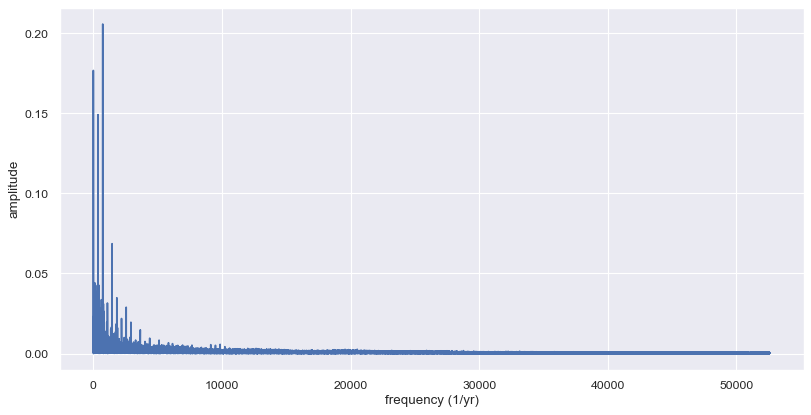

In [17]:
from scipy import fftpack

Y = fftpack.fft(power.values - power.mean())
t_span = toYearFraction(power.index[-1]) - toYearFraction(power.index[0])
f = np.linspace(0, len(Y), len(Y))/t_span

def plot_fft(fraction):
    plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(f[:len(Y)//fraction], np.abs(Y[:len(Y)//fraction])/len(Y));
    plt.xlabel('frequency (1/yr)')
    plt.ylabel('amplitude');

plot_fft(10)

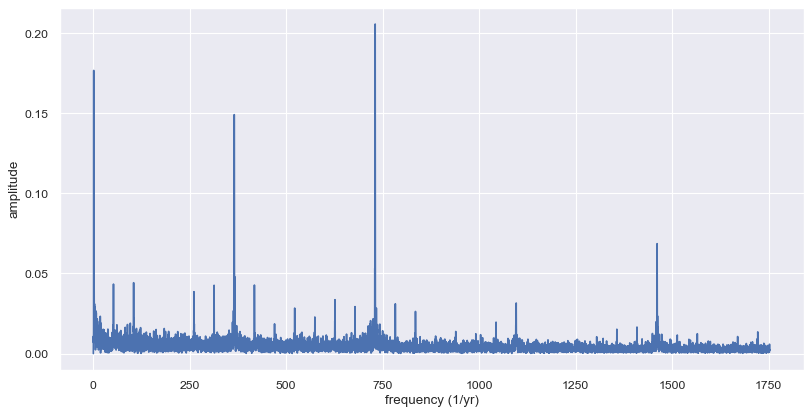

In [18]:
plot_fft(300)

In [19]:
# get the most dominant frequencies
def most_dominant_fft(top_n, fraction):
    fft_top_list = zip(f[:len(Y)//fraction], np.abs(Y[:len(Y)//fraction])/len(Y))
    return sorted(fft_top_list, key=lambda t: t[1], reverse=True)[:top_n]

most_dominant_fft(5, 300)

[(730.4305054364902, 0.2056646475986917),
 (1.0137827972747955, 0.1767044942923004),
 (365.2152527182451, 0.14911943239434877),
 (730.6839511358089, 0.09047147514820403),
 (1461.114456572299, 0.06857211720770728)]

In [20]:
1 / 730.4305054364902 * 365 # this is about every half a day

0.4997053070529735

In [21]:
1 / 1.0137827972747955 # this is about every year

0.9864045855662122

In [22]:
1 / 365.2152527182451 * 365 # this is about everyday

0.999410614105947

In [23]:
1 / 1461.114456572299 * 365 * 24 # this is about every 6-hours

5.995423534820482

Add our finding in the model !

$$ y(t) = A + B\sin(2\pi f_1 t) + C\cos(2\pi f_2 t) + D\sin(2\pi f_3 t) + E\cos(2\pi f_4 t), $$

where $t$ in expressed in units of years.

Now, we got the most dominant frequencies that make up the series. I interpreted the numbers and found that it's a lot that made sense. The pattern of household consumption appears every year, every day, every half-day, and every quarter of a day. Next, let's create Fourier features and see is the residauls look better!

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class FourierComponents(BaseEstimator, TransformerMixin):
    def __init__(self, freqs):
        """Create features based on sin(2*pi*f*t) and cos(2*pi*f*t)."""
        self.freqs = freqs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = np.zeros((X.shape[0], 2*len(self.freqs)))
        
        for i, f in enumerate(self.freqs):

            Xt[:, 2*i]= np.cos(2*np.pi*f*X.values).reshape(-1)
            Xt[:, 2*i + 1] = np.sin(2*np.pi*f*X.values).reshape(-1)
    
        return Xt

In [25]:
# construct and train pipeline
from sklearn.pipeline import FeatureUnion

# perform train/test split
cutoff = 2010
df_train, df_test, y_train, y_test = ts_train_test_split(data, cutoff, 'Global_active_power')

# construct and train pipeline

trend_col = ColumnSelectTransformer("decimal_time", need_reshape=True)
poly = PolynomialFeatures(degree=1)
trend_pipe = Pipeline([('trend_col', trend_col),
                 ('drift', poly),
                 ])

fourier_col = ColumnSelectTransformer("decimal_time")
fourier = FourierComponents([730.43, 1.01, 365.22, 1461.11])
seasonal_pipe = Pipeline([("fourier_col", fourier_col),
                    ("fourier", fourier)])


feature_union = FeatureUnion([
    ("trend_feature", trend_pipe),
    ("seasonal_feature", seasonal_pipe)
])

# construct and train pipeline
lr = LinearRegression()
baseline = Pipeline([
    ('feature_union', feature_union),
    ('regressor', lr)
])

baseline.fit(df_train, y_train)
# make predictions
y_pred = baseline.predict(data)
resd = power - y_pred
print("Test set R^2: {:g}".format(baseline.score(df_test, y_test)))

Test set R^2: -0.0928295


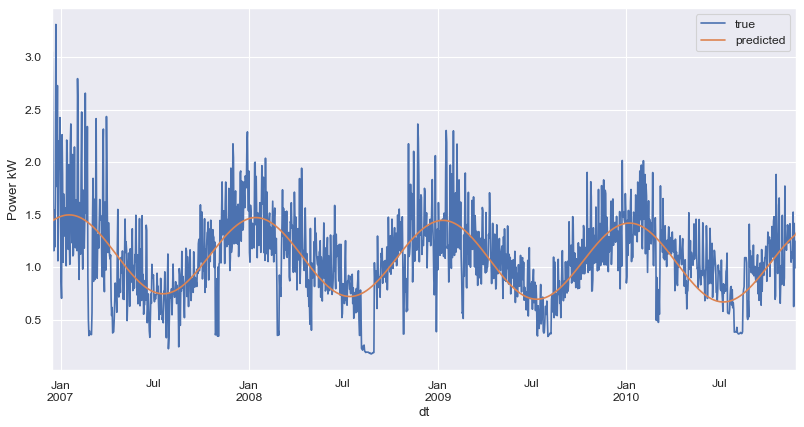

In [26]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

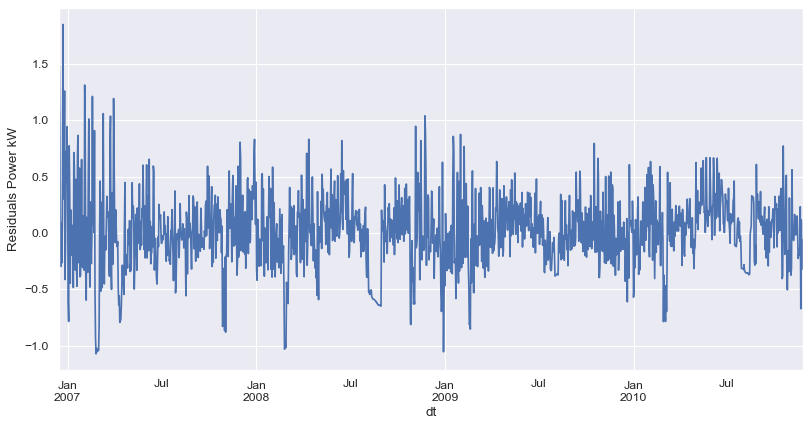

In [27]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd.resample("D").mean().plot()

Wow, it looks more stationary now!